In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

from plotly import tools
from plotly.graph_objs import *
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

import plotly.graph_objs as go
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os, json, itertools

from glob import glob
from tqdm import tqdm
from sklearn.grid_search import ParameterGrid
from sklearn import *
from copy import deepcopy
from scipy.stats import boxcox
from scipy.stats.stats import pearsonr, spearmanr
from shapely.geometry import Polygon
from collections import Counter

import statsmodels.api as sm
from scipy.stats.mstats import zscore

from modules import correlation, evaluation, query, residual, visualization

sns.set(color_codes=True)

loo = model_selection.LeaveOneOut()
scaler = preprocessing.StandardScaler()

data_dir = os.path.join('..','..','data')

# Dictionary File 
df_dictionary = pd.read_csv(os.path.join(data_dir,'shapefiles','csv','addrcode-dictionary.csv')) 
df_dictionary['addrcode'] = df_dictionary['addrcode'].astype('int')
df_dictionary = df_dictionary.fillna('')
df_dictionary.head(1)

/home/poom/.local/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning:

This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.

/home/poom/.local/lib/python3.5/site-packages/sklearn/grid_search.py:42: DeprecationWarning:

This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.

/home/poom/.local/lib/python3.5/site-packages/sklearn/learning_curve.py:22: DeprecationWarning:

This module was deprecated in version 0.18 in favor of the model_selection module into which all the functions are moved. This module will be removed in 0.20



,addrcode,subdistrict_th,subdistrict_en,district_code,district_th,district_en,province_code,province_th,province_en,LAT,LONG,Population
0,100101,พระบรมมหาราชวัง,Phra Borom Maha Ratchawang,1001,พระนคร,Phra Nakhon,10,กรุงเทพมหานคร,Bangkok,13.751,100.492,4089


In [2]:
df_rainfall = pd.read_csv(os.path.join(data_dir,'weather','csv','rainfall.csv')) 
df_rainfall['addrcode'] = df_rainfall['addrcode'].astype('int')
df_rainfall['date'] = pd.to_datetime(df_rainfall['date'], format='%Y-%m')
df_rainfall = df_rainfall.set_index('date')
df_rainfall = df_rainfall['2015':'2017']
df_rainfall = df_rainfall.set_index('addrcode')
df_rainfall = df_rainfall.sort_index()
df_rainfall = df_rainfall.drop('rainfall_sum', axis=1)
df_rainfall.columns = ['rainfall']
df_rainfall = df_rainfall.groupby('addrcode').sum()
df_rainfall.head()

,rainfall
addrcode,
8101,15512.96
8103,29964.56
8108,7491.14
100101,5006.34
100102,5006.34


In [3]:
df_temperature = pd.read_csv(os.path.join(data_dir,'weather','csv','temperature.csv')) 
df_temperature['addrcode'] = df_temperature['addrcode'].astype('int')
df_temperature['date'] = pd.to_datetime(df_temperature['date'], format='%Y-%m')
df_temperature = df_temperature.set_index('date')
df_temperature = df_temperature['2015':'2017']
df_temperature = df_temperature.set_index('addrcode')
df_temperature = df_temperature.sort_index()
df_temperature.columns = ['temperature']
df_temperature = df_temperature.groupby('addrcode').mean()
df_temperature.head()

,temperature
addrcode,
8101,0.000000
8103,27.299444
8108,28.495000
100101,36.594722
100102,36.733611


In [8]:
def get_rainfall(df_rainfall, addrcode):
    if addrcode in df_rainfall.index:
        return df_rainfall.loc[addrcode]['rainfall']
    return df_rainfall['rainfall'].mean()

def get_temperature(df_temperature, addrcode):
    if addrcode in df_temperature.index:
        return df_temperature.loc[addrcode]['temperature']
    return df_temperature['temperature'].mean()

def get_category(df_residual_corr, addrcode, col_name, q):
    
    q1, q2 = q
    
    value = df_residual_corr.loc[addrcode][col_name]
    if value > q2: return 'Bad'
    elif value > q1: return 'Average'
    else: return 'Good'

def get_residual_category(df_residual_corr):
        
    q_entry = {
        'error':[df_residual_corr.describe().loc['25%']['error'], df_residual_corr.describe().loc['75%']['error']],
        'norm_error':[df_residual_corr.describe().loc['25%']['norm_error'], df_residual_corr.describe().loc['75%']['norm_error']],
    }
    
    addrcodes = df_residual_corr.index.values
    error_categories, norm_error_categories, rainfalls, temperatures = [], [], [], []
    for addrcode in addrcodes:
        error_categories.append(get_category(df_residual_corr, addrcode, 'error', q_entry['error']))
        norm_error_categories.append(get_category(df_residual_corr, addrcode, 'norm_error', q_entry['norm_error']))
        rainfalls.append(get_rainfall(df_rainfall, addrcode))
        temperatures.append(get_temperature(df_temperature, addrcode))
        
    df_residual_corr['rainfall'] = rainfalls
    df_residual_corr['temperature'] = temperatures

    df_residual_corr['error_category'] = error_categories
    df_residual_corr['norm_error_category'] = norm_error_categories
    df_residual_corr['gsv_density'] = df_residual_corr['image_area']/df_residual_corr['land_area']
    df_residual_corr['rainfall_density'] = df_residual_corr['rainfall']/df_residual_corr['land_area']

    df_residual_corr = df_residual_corr.drop([
        'jar','bin','bucket','tire','pottedplant','bowl','cup','vase',
        'n_jar','n_bin','n_bucket','n_tire','n_pottedplant','n_bowl','n_cup','n_vase',
        'a_jar','a_bin','a_bucket','a_tire','a_pottedplant','a_bowl','a_cup','a_vase',
        'ngsv_jar','ngsv_bin','ngsv_bucket','ngsv_tire','ngsv_pottedplant','ngsv_bowl','ngsv_cup','ngsv_vase',
        'image_area', 'land_area','area',
        'n_total','total','population',
        'rainfall','error','predicted',
        'cases', 'normalized_cases'
    ], axis=1)
    
    return df_residual_corr, q_entry

def plot_distribution(df_residual_corr, col_name):
    
    _=plt.figure(figsize=((10,3)))
    _=sns.set_context("poster", font_scale = 1)
    fig = sns.boxplot(df_residual_corr[col_name])
    _ = sns.swarmplot(df_residual_corr[col_name], color=".25", size=8)
    _=plt.title('Distribution of Prediction Errors, '+col_name)
    _=fig.set_xlabel('Residual Error')
    
def plot_residual_heatmap(df_residual_corr):
    
    df_residual_corr['norm_error'] = 100*df_residual_corr['norm_error']
    

#     plot_distribution(df_residual_corr, 'error')
    plot_distribution(df_residual_corr, 'norm_error')
    
    cols = df_residual_corr.columns.tolist()
    cols = cols[-2:] + cols[:-2]
    df_residual_corr = df_residual_corr[cols].copy()

    df_residual_corr, q_entry = get_residual_category(df_residual_corr)
    
    plt.figure(figsize=(10,1.5))
    sns.set(font_scale=1.3)
    sns.heatmap(df_residual_corr.corr().loc[['norm_error']], annot=True, fmt=".2f", cmap="RdYlBu", vmin=-0.7, vmax=0.7)
    plt.show()
    
    return df_residual_corr, q_entry

In [9]:
def residual_corr_plot(df_residual_corr, title, x_col, y_col, x_axis_name, y_axis_name, out_filename, is_hue=True):
    flatui = ["#2ecc71","#34495e",  "#e74c3c"]
    
    if is_hue:
        if x_col == 'error': 
            hue = 'error_category'
        elif x_col == 'norm_error':
            hue = 'norm_error_category'
    else:
        hue = None
    
    _=plt.figure(figsize=((10,10)))
    _=sns.set_context("poster", font_scale = 1)
    fig = sns.FacetGrid(data=df_residual_corr, hue=hue, size=8, hue_order=["Good", "Average", "Bad"], palette=sns.color_palette(flatui), hue_kws=dict(marker=["o", "D","s"]))\
        .map(plt.scatter, x_col, y_col) \
        .add_legend() 
    fig = sns.regplot(x=x_col, y=y_col, data=df_residual_corr, scatter=False)
    
    
    X = df_residual_corr[x_col].values
    y = df_residual_corr[y_col].values
    
    pearson_val = pearsonr(X, y)
    spearman_val = spearmanr(X, y)

    _=fig.set_title(
        title+ \
        '\nPearson: '+str(round(pearson_val[0],4))+ ', p-value: '+str(round(pearson_val[1],4))+ \
        '\nSpearman: '+str(round(spearman_val[0],4))+', p-value: '+str(round(spearman_val[1],4))
    )
    _=fig.set_xlabel(x_axis_name)
    _=fig.set_ylabel(y_axis_name)

    _=fig.figure.savefig(out_filename+'.svg', bbox_inches='tight')
    _=fig.figure.savefig(out_filename+'.png', bbox_inches='tight')


def residual_corr_split_plot(df_residual_corr, title, x_col, y_col, x_axis_name, y_axis_name, out_filename):
    flatui = ["#2ecc71","#34495e",  "#e74c3c"]
    
    if x_col == 'error': 
        hue = 'error_category'
    elif x_col == 'norm_error':
        hue = 'norm_error_category'
    
    
    _=plt.figure(figsize=((10,10)))
    _=sns.set_context("poster", font_scale = 1)
    fig = sns.lmplot(x=x_col, y=y_col, data=df_residual_corr, size=8, 
                     hue=hue, hue_order=["Good", "Average", "Bad"],
                    palette=sns.color_palette(flatui), markers=["o", "D","s"])
    
    X = df_residual_corr[x_col].values
    y = df_residual_corr[y_col].values
    
    pearson_val = pearsonr(X, y)
    spearman_val = spearmanr(X, y)

    _=plt.title(
        title+ \
        '\nPearson: '+str(round(pearson_val[0],4))+ ', p-value: '+str(round(pearson_val[1],4))+ \
        '\nSpearman: '+str(round(spearman_val[0],4))+', p-value: '+str(round(spearman_val[1],4))
    )
    _=plt.xlabel(x_axis_name)
    _=plt.ylabel(y_axis_name)

#     _=fig.figure.savefig(out_filename+'.svg', bbox_inches='tight')
#     _=fig.figure.savefig(out_filename+'.png', bbox_inches='tight')

# 1. Bangkok

In [10]:
df_features.columns

Index(['ngsv_bin', 'ngsv_bowl', 'ngsv_bucket', 'ngsv_cup', 'ngsv_jar',
       'ngsv_pottedplant', 'ngsv_tire', 'ngsv_vase', 'ngsv_total', 'n_bin',
       'n_bowl', 'n_bucket', 'n_cup', 'n_jar', 'n_pottedplant', 'n_tire',
       'n_vase', 'n_total', 'bin', 'bowl', 'bucket', 'cup', 'jar',
       'pottedplant', 'tire', 'vase', 'total', 'a_bin', 'a_bowl', 'a_cup',
       'a_bucket', 'a_jar', 'a_pottedplant', 'a_tire', 'a_vase', 'a_total',
       'population', 'cases', 'normalized_cases', 'area', 'image_area',
       'land_area', 'pop_density', 'predicted', 'error', 'norm_error'],
      dtype='object')

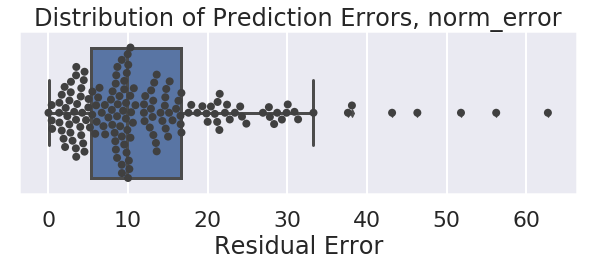

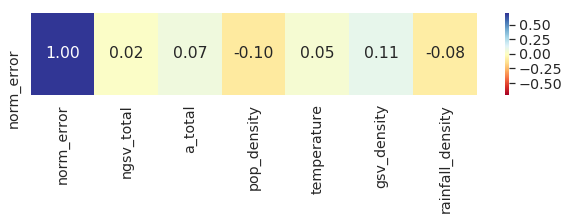

In [13]:
### Load Shapefile
with open(os.path.join(data_dir,'shapefiles','geojson','Bangkok-subdistricts.geojson')) as f:
    data_polygon = json.load(f)
# data_polygon['features'][0]['properties']

df_features = pd.read_csv(os.path.join('combined-dengue-case-features', 'Bangkok.csv')) 
df_features.set_index('addrcode', inplace=True)
# df_features = df_features.loc[df_features.error > df_features.error.mean()].copy()
# df_features.head(1)

# df_features.error = boxcox(df_features.error.values)[0]
# df_features.norm_error = boxcox(df_features.norm_error.values)[0]

df_residual_corr, q_entry = plot_residual_heatmap(df_features.copy())

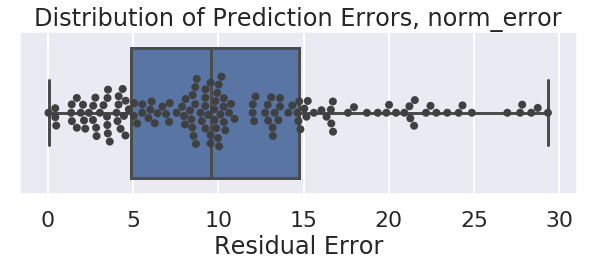

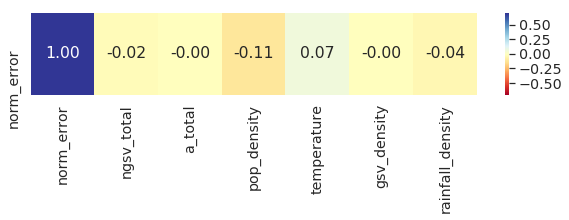

In [12]:
### Load Shapefile
with open(os.path.join(data_dir,'shapefiles','geojson','Bangkok-subdistricts.geojson')) as f:
    data_polygon = json.load(f)
# data_polygon['features'][0]['properties']

df_features = pd.read_csv(os.path.join('combined-dengue-case-features', 'Bangkok.csv')) 
df_features.set_index('addrcode', inplace=True)
df_features = df_features.loc[df_features.norm_error < df_features.norm_error.quantile()*3].copy()
# df_features.head(1)

# df_features.error = boxcox(df_features.error.values)[0]
# df_features.norm_error = boxcox(df_features.norm_error.values)[0]

df_residual_corr, q_entry = plot_residual_heatmap(df_features.copy())

In [14]:
# category='error_category'

# x_col='error'
# x_axis_name='Absolute Error'

# y_col='gsv_density'
# y_axis_name='GSV Density'

# residual_corr_plot(df_residual_corr, 
#                    title='Residual Analysis', 
#                    x_col=x_col, x_axis_name=x_axis_name,
#                    y_col=y_col, y_axis_name=y_axis_name,
#                    out_filename='Bangkok-gsv_density-residual-corr-1',
# #                    is_hue=False
#                   )

# category='error_category'

# x_col='error'
# x_axis_name='Absolute Error'

# y_col='gsv_density'
# y_axis_name='GSV Density'

# residual_corr_plot(df_residual_corr, 
#                    title='Residual Analysis', 
#                    x_col=x_col, x_axis_name=x_axis_name,
#                    y_col=y_col, y_axis_name=y_axis_name,
#                    out_filename='Bangkok-gsv_density-residual-corr-2',
#                    is_hue=False
#                   )

In [16]:
# category='norm_error_category'

# x_col='norm_error'
# x_axis_name='Absolute Error'

# y_col='pop_density'
# y_axis_name='pop_density'



# residual_corr_plot(df_residual_corr, 
#                    title='Residual Analysis', 
#                    x_col=x_col, x_axis_name=x_axis_name,
#                    y_col=y_col, y_axis_name=y_axis_name,
#                    out_filename=''
#                   )

# residual_corr_split_plot(df_residual_corr, 
#                    title='Residual Analysis', 
#                    x_col=x_col, x_axis_name=x_axis_name,
#                    y_col=y_col, y_axis_name=y_axis_name,
#                    out_filename=''
#                   )

# residual_corr_plot(df_residual_corr.loc[df_residual_corr[category] == 'Good'].copy(), 
#                    title='Residual Analysis', 
#                    x_col=x_col, x_axis_name=x_axis_name,
#                    y_col=y_col, y_axis_name=y_axis_name,
#                    out_filename=''
#                   )
# residual_corr_plot(df_residual_corr.loc[df_residual_corr[category] == 'Average'].copy(), 
#                    title='Residual Analysis', 
#                    x_col=x_col, x_axis_name=x_axis_name,
#                    y_col=y_col, y_axis_name=y_axis_name,
#                    out_filename=''
#                   )
# residual_corr_plot(df_residual_corr.loc[df_residual_corr[category] == 'Bad'].copy(), 
#                    title='Residual Analysis', 
#                    x_col=x_col, x_axis_name=x_axis_name,
#                    y_col=y_col, y_axis_name=y_axis_name,
#                    out_filename=''
#                   )

In [21]:
df_residual.describe()

,residual
count,159.000000
mean,0.129863
std,0.109054
min,0.000371
25%,0.053841
50%,0.099333
75%,0.166134
max,0.627214


In [20]:
# df_residual = df_features[['error']].copy()
# df_residual.columns = ['residual']

# visualization.choropleth_plot(
#     data_polygon, 
#     df_residual,
#     df_dictionary,
#     map_style='streets', # dark, satellite, streets, light, outdoors
#     cmap_name='RdYlGn', # Blues, viridis, RdYlGn, autumn, summer
#     none_data_rgba='rgba(255,255,255,0.5)',
#     opacity=0.8,
#     is_reverse=True,
#     save_file=True,
#     filename='Bangkok-dengue-case-residual.html'
# )


df_residual = df_features[['norm_error']].copy()
df_residual.columns = ['residual']

visualization.choropleth_plot(
    data_polygon, 
    df_residual,
    df_dictionary,
    map_style='streets', # dark, satellite, streets, light, outdoors
    cmap_name='RdYlGn', # Blues, viridis, RdYlGn, autumn, summer
    none_data_rgba='rgba(255,255,255,0.5)',
    opacity=0.8,
    is_reverse=True,
    save_file=True,
    filename='Bangkok-dengue-case-smape.html'
)

# 2. Nakhon

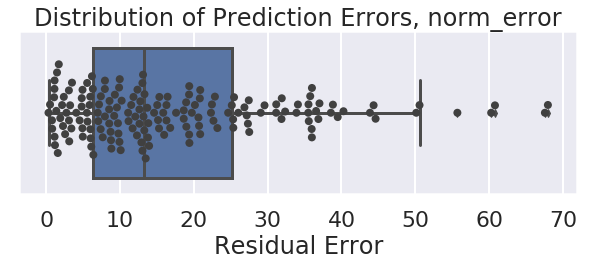

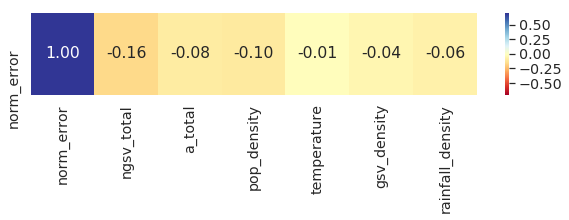

In [38]:
### Load Shapefile
with open(os.path.join(data_dir,'shapefiles','geojson','Nakhon-subdistricts.geojson')) as f:
    data_polygon = json.load(f)
# data_polygon['features'][0]['properties']

df_features = pd.read_csv(os.path.join('combined-dengue-case-features', 'Nakhon.csv')) 
df_features.set_index('addrcode', inplace=True)
# df_features = df_features.loc[df_features.norm_error < 0.5].copy()
# df_features.head(1)

# df_features.error = boxcox(df_features.error.values)[0]
# df_features.norm_error = boxcox(df_features.norm_error.values)[0]

df_residual_corr, q_entry = plot_residual_heatmap(df_features.copy())

In [37]:
# ### Load Shapefile
# with open(os.path.join(data_dir,'shapefiles','geojson','Nakhon-subdistricts.geojson')) as f:
#     data_polygon = json.load(f)
# # data_polygon['features'][0]['properties']

# df_features = pd.read_csv(os.path.join('combined-dengue-case-features', 'Nakhon.csv')) 
# df_features.set_index('addrcode', inplace=True)
# df_features = df_features.loc[df_features.norm_error < df_features.norm_error.quantile()*3].copy()


# # df_features = df_features.loc[df_features.norm_error < 0.5].copy()
# # df_features.head(1)

# # df_features.error = boxcox(df_features.error.values)[0]
# # df_features.norm_error = boxcox(df_features.norm_error.values)[0]

# df_residual_corr, q_entry = plot_residual_heatmap(df_features.copy())

In [24]:
# category='error_category'

# x_col='error'
# x_axis_name='Absolute Error'

# y_col='temperature'
# y_axis_name='Temperature'

# residual_corr_plot(df_residual_corr, 
#                    title='Residual Analysis', 
#                    x_col=x_col, x_axis_name=x_axis_name,
#                    y_col=y_col, y_axis_name=y_axis_name,
#                    out_filename='Nakhon-temperature-residual-corr',
# #                    is_hue=False
#                   )

In [39]:
# df_residual = df_residual_corr[['error']].copy()
# df_residual.columns = ['residual']

# visualization.choropleth_plot(
#     data_polygon, 
#     df_residual,
#     df_dictionary,
#     map_style='streets', # dark, satellite, streets, light, outdoors
#     cmap_name='RdYlGn', # Blues, viridis, RdYlGn, autumn, summer
#     none_data_rgba='rgba(255,255,255,0.5)',
#     opacity=0.8,
#     is_reverse=True,
#     save_file=True,
#     filename='Nakhon-dengue-case-residual.html'
# )

df_residual = df_residual_corr[['norm_error']].copy()
df_residual.columns = ['residual']

visualization.choropleth_plot(
    data_polygon, 
    df_residual,
    df_dictionary,
    map_style='streets', # dark, satellite, streets, light, outdoors
    cmap_name='RdYlGn', # Blues, viridis, RdYlGn, autumn, summer
    none_data_rgba='rgba(255,255,255,0.5)',
    opacity=0.8,
    is_reverse=True,
    save_file=True,
    filename='Nakhon-dengue-case-smape.html'
)

# 3. Krabi

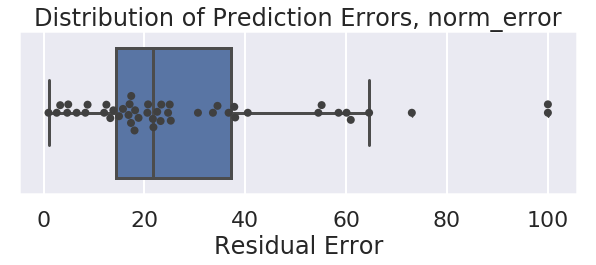

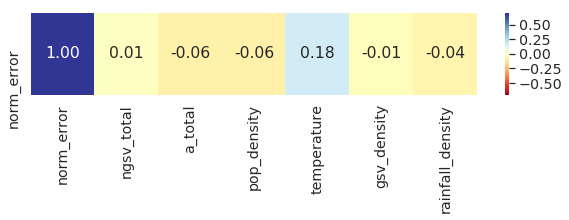

In [40]:
### Load Shapefile
with open(os.path.join(data_dir,'shapefiles','geojson','Krabi-subdistricts.geojson')) as f:
    data_polygon = json.load(f)
# data_polygon['features'][0]['properties']

df_features = pd.read_csv(os.path.join('combined-dengue-case-features', 'Krabi.csv')) 
df_features.set_index('addrcode', inplace=True)
# df_features = df_features.loc[df_features.norm_error < 0.5].copy()

# df_features.head(1)

df_residual_corr, q_entry = plot_residual_heatmap(df_features.copy())

In [41]:
# ### Load Shapefile
# with open(os.path.join(data_dir,'shapefiles','geojson','Krabi-subdistricts.geojson')) as f:
#     data_polygon = json.load(f)
# # data_polygon['features'][0]['properties']

# df_features = pd.read_csv(os.path.join('combined-dengue-case-features', 'Krabi.csv')) 
# df_features.set_index('addrcode', inplace=True)
# df_features = df_features.loc[df_features.norm_error < df_features.norm_error.quantile()*3].copy()

# # df_features.head(1)

# df_residual_corr, q_entry = plot_residual_heatmap(df_features.copy())

In [42]:
df_residual = df_residual_corr[['norm_error']].copy()
df_residual.columns = ['residual']

visualization.choropleth_plot(
    data_polygon, 
    df_residual,
    df_dictionary,
    map_style='streets', # dark, satellite, streets, light, outdoors
    cmap_name='RdYlGn', # Blues, viridis, RdYlGn, autumn, summer
    none_data_rgba='rgba(255,255,255,0.5)',
    opacity=0.8,
    is_reverse=True,
    save_file=True,
    filename='Krabi-dengue-case-smape.html'
)

In [34]:
# residual_corr_plot(df_residual_corr, 
#                    title='Residual Analysis', 
#                    x_col='norm_error',  x_axis_name='Symmetric Absolute Percentage Error',
#                    y_col='temperature',y_axis_name='Temperature',
#                    out_filename='Krabi-temerature-smape'
#                   )

In [31]:
# residual_corr_plot(df_residual_corr, 
#                    title='Residual Analysis', 
#                    x_col='error',        x_axis_name='Absolute Error',
#                    y_col='rainfall_density', y_axis_name='Rainfall Density',
#                    out_filename='Krabi-rainfall-residual-corr'
#                 )

# residual_corr_plot(df_residual_corr, 
#                    title='Residual Analysis', 
#                    x_col='error',  x_axis_name='Absolute Error',
#                    y_col='a_total',y_axis_name='Total Breeding Site Density',
#                    out_filename='Krabi-bs_density-residual-corr'
#                   )

# residual_corr_plot(df_residual_corr, 
#                    title='Residual Analysis', 
#                    x_col='error',  x_axis_name='Absolute Error',
#                    y_col='pop_density',y_axis_name='Population Density',
#                    out_filename='Krabi-pop_density-residual-corr'
#                   )

In [32]:
# category='error_category'

# x_col='error'
# x_axis_name='Absolute Error'

# y_col='pop_density'
# y_axis_name='pop_density'



# residual_corr_plot(df_residual_corr, 
#                    title='Residual Analysis', 
#                    x_col=x_col, x_axis_name=x_axis_name,
#                    y_col=y_col, y_axis_name=y_axis_name,
#                    out_filename=''
#                   )

# residual_corr_split_plot(df_residual_corr, 
#                    title='Residual Analysis', 
#                    x_col=x_col, x_axis_name=x_axis_name,
#                    y_col=y_col, y_axis_name=y_axis_name,
#                    out_filename=''
#                   )

# residual_corr_plot(df_residual_corr.loc[df_residual_corr[category] == 'Good'].copy(), 
#                    title='Residual Analysis', 
#                    x_col=x_col, x_axis_name=x_axis_name,
#                    y_col=y_col, y_axis_name=y_axis_name,
#                    out_filename=''
#                   )
# residual_corr_plot(df_residual_corr.loc[df_residual_corr[category] == 'Average'].copy(), 
#                    title='Residual Analysis', 
#                    x_col=x_col, x_axis_name=x_axis_name,
#                    y_col=y_col, y_axis_name=y_axis_name,
#                    out_filename=''
#                   )
# residual_corr_plot(df_residual_corr.loc[df_residual_corr[category] == 'Bad'].copy(), 
#                    title='Residual Analysis', 
#                    x_col=x_col, x_axis_name=x_axis_name,
#                    y_col=y_col, y_axis_name=y_axis_name,
#                    out_filename=''
#                   )

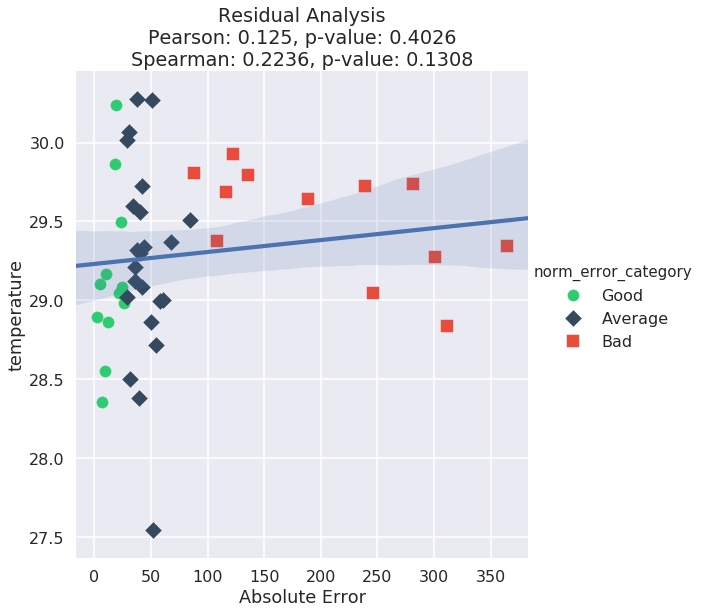

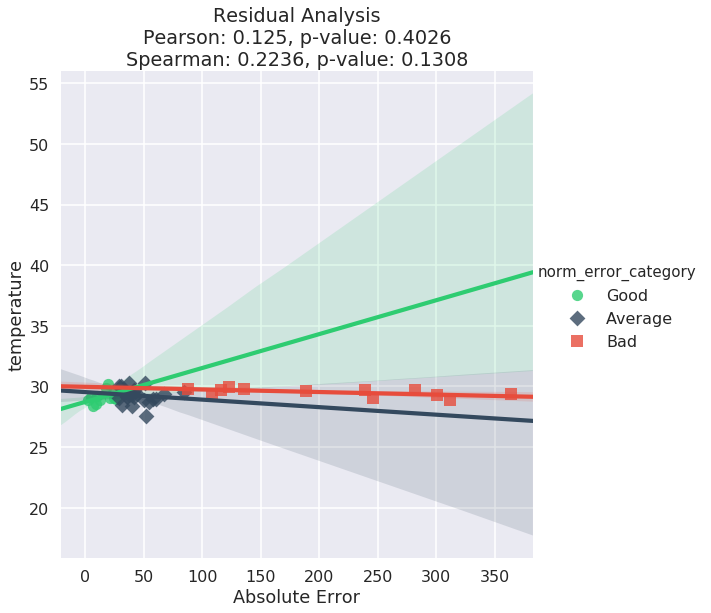

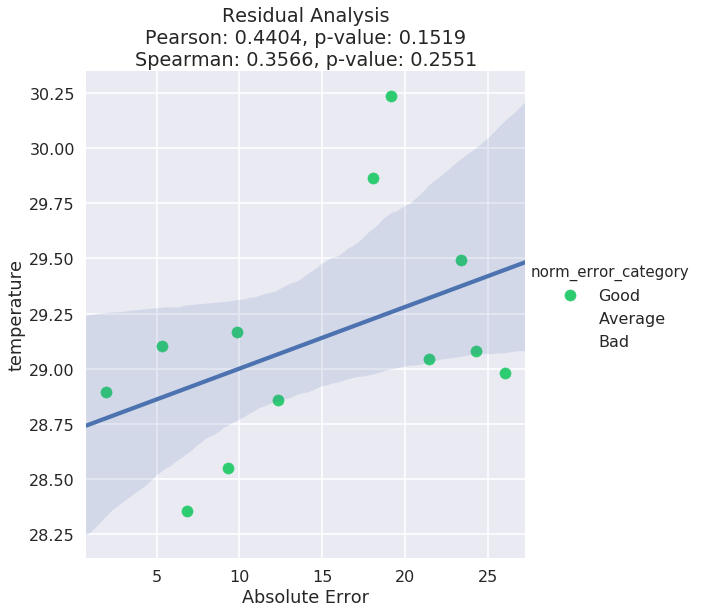

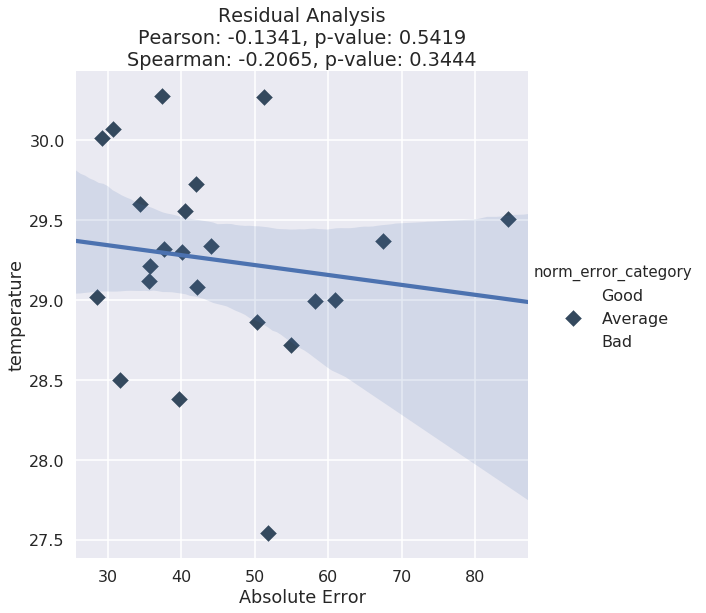

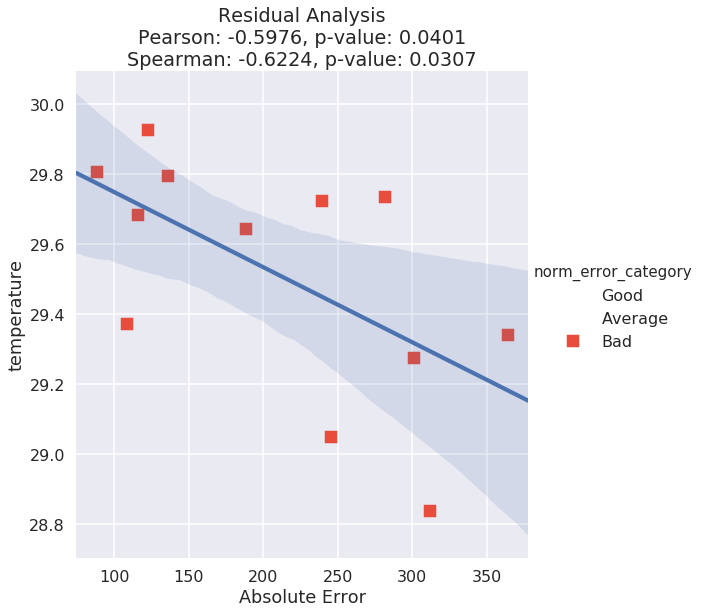